In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [3]:
def function(x):
    return x**2

In [4]:
inputs = np.linspace(-0.5, 0.5, 11)
inputs

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

In [5]:
outputs = np.array([function(x) for x in inputs])
outputs

array([0.25, 0.16, 0.09, 0.04, 0.01, 0.  , 0.01, 0.04, 0.09, 0.16, 0.25])

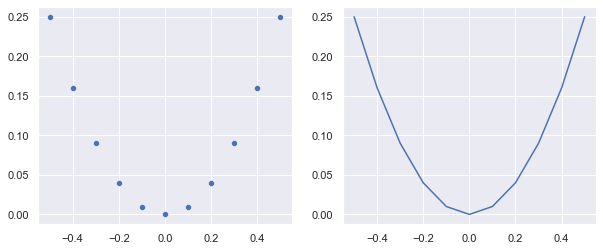

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.scatterplot(ax=axes[0], x=inputs, y=outputs)
sns.lineplot(ax=axes[1], x=inputs, y=outputs)
plt.show()

In [7]:
def generate_samples(n=100):
    X1 = np.random.rand(n) - 0.5
    # Generate outputs 
    X2 = X1 * X1
    # Stack Arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    return np.hstack((X1, X2))    

In [8]:
array_1 = np.random.rand(5) - 0.5
array_1

array([ 0.40914919, -0.33617335, -0.22301174,  0.29958536, -0.1797667 ])

In [9]:
array_2 = array_1 * array_1
array_2

array([0.16740306, 0.11301252, 0.04973423, 0.08975139, 0.03231607])

In [10]:
array_1_reshaped = array_1.reshape(5, 1)
array_1_reshaped

array([[ 0.40914919],
       [-0.33617335],
       [-0.22301174],
       [ 0.29958536],
       [-0.1797667 ]])

In [11]:
array_2_reshaped = array_2.reshape(5, 1)
array_2_reshaped

array([[0.16740306],
       [0.11301252],
       [0.04973423],
       [0.08975139],
       [0.03231607]])

In [12]:
np.hstack((array_1_reshaped, array_2_reshaped))

array([[ 0.40914919,  0.16740306],
       [-0.33617335,  0.11301252],
       [-0.22301174,  0.04973423],
       [ 0.29958536,  0.08975139],
       [-0.1797667 ,  0.03231607]])

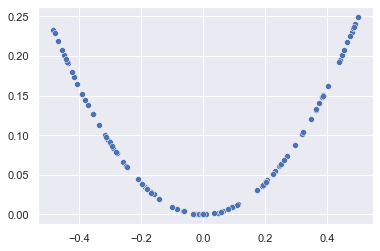

In [13]:
data = generate_samples()

sns.scatterplot(x=data[:, 0], y=data[:, 1])
plt.show()

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

def discriminator_model(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation="relu", kernel_initializer="he_uniform", input_dim=n_inputs))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [36]:
def generate_real_samples(n):
    X1 = np.random.rand(n) - 0.5
    X2 = X1 * X1
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.ones((n, 1))
    return X, y

def generate_fake_samples(n):
    X1 = -1 + np.random.rand(n)*2
    X2 = -1 + np.random.rand(n)*2
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.zeros((n, 1))
    return X, y

In [37]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch/2)
    for iteration in range(n_epochs):
        X_real, y_real = generate_real_samples(half_batch)
        model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(half_batch)
        model.train_on_batch(X_fake, y_fake)
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        print(iteration, acc_real, acc_fake)

In [52]:
def generator_model(latent_dimension, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation="relu", kernel_initializer="he_uniform", input_dim=latent_dimension))
    model.add(Dense(n_outputs, activation="linear"))
    return model

def generate_latent_points(latent_dimension, n):
    x_input = np.random.randn(latent_dimension*n)
    # Reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dimension)
    return x_input

def generate_fake_samples(generator, latent_dimension, n):
    # Generate points in the latent space
    x_input = generate_latent_points(latent_dimension, n)
    # Predict outputs
    X = generator.predict(x_input)
    y = np.zeros((n, 1))
    return X, y

In [53]:
def GAN(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss="binary_crossentropy", optimizer="adam")
    return model

In [54]:
def evaluator(epoch, generator, discriminator, latent_dimension, n=100):
    x_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(generator, latent_dimension, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    print(epoch, acc_real, acc_fake)
    sns.scatterplot(x=x_real[:, 0], y=x_real[:, 1])
    sns.scatterplot(x=x_fake[:, 0], y=x_fake[:, 1])
    filename = "generated_plot_e%03d.png" % (epoch + 1)
    plt.savefig(filename)
    plt.close()

In [57]:
def train_gan(generator, discriminator, gan_model, latent_dimension, n_epochs=10000, n_batch=128, n_eval=1000):
    half_batch = int(n_batch/2)
    for epoch in range(n_epochs):
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_samples(generator, latent_dimension, half_batch)
        discriminator.train_on_batch(x_real, y_real)
        discriminator.train_on_batch(x_fake, y_fake)
        x_gan = generate_latent_points(latent_dimension, n_batch)
        y_gan = np.ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)
        if (epoch+1) % n_eval == 0:
            evaluator(epoch, generator, discriminator, latent_dimension)

In [58]:
latent_dimension = 5
discriminator = discriminator_model()
generator = generator_model(latent_dimension)
gan_model = GAN(generator, discriminator)
train_gan(generator, discriminator, gan_model, latent_dimension)

2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 1000us/step


4/4 [==============================] - 0s 5ms/step
999 0.5 0.6899999976158142
2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 2ms/step
1999 0.5299999713897705 0.8100000023841858
2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 1000us/step


2/2 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 3ms/step
2999 0.41999998688697815 0.5699999928474426
2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step
3999 0.5400000214576721 0.6200000047683716
2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step
4999 0.699999988079071 0.27000001072883606
2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 1000us/step


4/4 [==============================] - 0s 1ms/step
5999 0.8700000047683716 0.3100000023841858
2/2 [==============================] - 0s 1000us/step


2/2 [==============================] - 0s 999us/step


2/2 [==============================] - 0s 16ms/step


4/4 [==============================] - 0s 0s/step
6999 0.8899999856948853 0.27000001072883606
2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 999us/step


4/4 [==============================] - 0s 0s/step
7999 0.6800000071525574 0.36000001430511475
2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 1000us/step


2/2 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 0s/step
8999 0.5 0.6399999856948853
2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 0s/step
9999 0.17000000178813934 0.8799999952316284
